In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import math
import time
from io import StringIO
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from dataset import *
from torch.utils.data import DataLoader

In [13]:
torch.__version__

'1.6.0+cu101'

In [3]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print (device)

cuda:2


In [4]:
# if torch.cuda.is_available():
#     print (torch.cuda.current_device())
#     torch.cuda.set_device(device)
#     print (torch.cuda.current_device())

0
2


In [4]:
torch.set_printoptions(sci_mode=False)

In [5]:
root_folder = 'data/simple_reacher/training'
number_of_trajectories = 5000
batch_size = 32

In [39]:
root_folder = 'data/simple_reacher/sample_data_all_limited_joints'
number_of_trajectories = 5

In [7]:
start = time.time()
base = SimpleReacherBaseDataset(root_folder, number_of_trajectories, device)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 4.342281341552734 sec


In [41]:
start = time.time()
ondemand = SimpleReacherOnDemandDataset(root_folder, number_of_trajectories)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 0.07968378067016602 sec


In [5]:
start = time.time()
preloaded = SimpleReacherPreLoadedDataset(root_folder, number_of_trajectories)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 10.221627950668335 sec


In [8]:
base.trajectory_data.shape

torch.Size([108673, 9])

In [7]:
len(ondemand)

2194

In [8]:
print(preloaded.trajectory_data.shape)
print(preloaded.image_data.shape)

(2194, 9)
(2194, 62500)


In [9]:
idx = np.random.randint(len(ondemand.trajectory_data), size=(batch_size))

In [10]:
idx

array([ 519, 1346,  545,  451,  926, 1596, 1284, 1450,  408,  921, 1548,
       1210,  641,  618, 1954, 1747, 2140, 1758,  242, 1181,  180, 1143,
        334, 1216, 1971, 2152, 2148,  542,   86, 1576,   22,  409])

In [11]:
start = time.time()
ondemandBatch = ondemand[idx]
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 0.10364007949829102 sec


In [12]:
start = time.time()
preloadedBatch = preloaded[idx]
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 0.001249074935913086 sec


In [13]:
np.all(ondemandBatch['images'] == preloadedBatch['images'])

True

In [14]:
onedemandLoader = DataLoader(ondemand, batch_size=batch_size, shuffle=True)
preloadedLoader = DataLoader(preloaded, batch_size=batch_size, shuffle=True)

In [15]:
epochs = 1

In [16]:
def simulate_training(dataLoader):
    start = time.time()
    builder = StringIO()
    for e in range(epochs):
        for i, data in enumerate(dataLoader):
            builder.write('Epoch {}: Running batch index = {} with data shape = {}'.format(e, i, data['images'].shape))
            builder.write('\n')
            break
    print ("Time Taken: {} sec".format(time.time() - start))
    log = builder.getvalue()
    builder.close()
    return log

In [17]:
log1 = simulate_training(onedemandLoader)

Time Taken: 0.2524890899658203 sec


In [18]:
log1

'Epoch 0: Running batch index = 0 with data shape = torch.Size([32, 62500])\n'

In [19]:
log2 = simulate_training(preloadedLoader)

Time Taken: 0.005193948745727539 sec


In [20]:
log2

'Epoch 0: Running batch index = 0 with data shape = torch.Size([32, 62500])\n'

In [29]:
sys.getsizeof(ondemand.trajectory_data)

158080

In [27]:
sys.getsizeof(preloaded.image_data)

137125112

In [7]:
start = time.time()
train_data = SimpleReacherOnDemandDataset(root_folder, range(4750), device=None)
test_data = SimpleReacherOnDemandDataset(root_folder, range(4750, 5000), device=None)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 21.97927212715149 sec


In [7]:
train_data = SimpleReacherOnDemandDataset(root_folder, range(5000), device=device)

In [8]:
print (train_data.trajectory_data.shape)

torch.Size([108673, 9])


In [9]:
print (torch.min(train_data.trajectory_data[:, :1]))
print (torch.max(train_data.trajectory_data[:, :1]))
print (torch.min(train_data.trajectory_data[:, 1:3]))
print (torch.max(train_data.trajectory_data[:, 1:3]))
print (torch.min(train_data.trajectory_data[:, 3:6]))
print (torch.max(train_data.trajectory_data[:, 3:6]))
print (torch.min(train_data.trajectory_data[:, 6:]))
print (torch.max(train_data.trajectory_data[:, 6:]))
# print (torch.min(test_data.trajectory_data[:, :3]))
# print (torch.max(test_data.trajectory_data[:, :3]))
# print (torch.min(test_data.trajectory_data[:, 3:6]))
# print (torch.max(test_data.trajectory_data[:, 3:6]))
# print (torch.min(test_data.trajectory_data[:, 6:]))
# print (torch.max(test_data.trajectory_data[:, 6:]))
print (np.pi)

tensor(-3.1352, device='cuda:2', dtype=torch.float64)
tensor(3.1405, device='cuda:2', dtype=torch.float64)
tensor(-2.8946, device='cuda:2', dtype=torch.float64)
tensor(2.8969, device='cuda:2', dtype=torch.float64)
tensor(-3.1364, device='cuda:2', dtype=torch.float64)
tensor(3.1412, device='cuda:2', dtype=torch.float64)
tensor(-0.1990, device='cuda:2', dtype=torch.float64)
tensor(0.1985, device='cuda:2', dtype=torch.float64)
3.141592653589793


In [10]:
actions = train_data.trajectory_data[:, 6:]
print (actions.shape)
print (torch.max(actions))
print (torch.min(actions))
print (torch.where(torch.abs(actions) <= 0.15)[0].shape)
print (torch.where(torch.abs(actions) > 0.15)[0].shape)
print (torch.unique(torch.where(actions > 0.15)[0]))

torch.Size([108673, 3])
tensor(0.1985, device='cuda:2', dtype=torch.float64)
tensor(-0.1990, device='cuda:2', dtype=torch.float64)
torch.Size([325294])
torch.Size([725])
tensor([  3035,   3036,   3037,   3038,   3039,   3040,   3041,   3042,   4013,
          4014,   4015,   7230,   7768,   7769,   7770,   8058,   8059,   8060,
          8061,   8062,   8063,   8064,   8065,   8066,   8067,   8820,   8821,
          8822,   8823,   8824,  10450,  10451,  10452,  10453,  10454,  10455,
         10506,  10507,  10508,  10509,  10510,  10511,  10656,  10657,  10658,
         10659,  10660,  10661,  10662,  10696,  10697,  10698,  10699,  10700,
         12483,  12484,  12485,  12486,  13834,  13835,  14230,  14231,  14232,
         15638,  15639,  15640,  15641,  15784,  15785,  15786,  15787,  18005,
         18006,  18007,  18008,  18009,  18010,  18011,  19591,  19592,  19593,
         19594,  19595,  19596,  19597,  20891,  20892,  20893,  20894,  20895,
         20896,  20897,  20910

In [43]:
train_data.trajectory_data[108616]

tensor([-1.9516, -1.8614, -1.2859, -1.5344, -2.5449, -1.3733,  0.0417, -0.0683,
         0.2720], device='cuda:2', dtype=torch.float64)

In [38]:
train_data.cumulative_index

tensor([        0.,        24.,        51.,  ...,    108597.,    108627.,
           108648.])

In [40]:
import bisect
rowId = 51
pos = bisect.bisect_left(train_data.cumulative_index.numpy(), rowId)
if train_data.cumulative_index[pos] < rowId:
    pos -= 1
print ('Trajectory containing row index : {} = {}'.format(rowId, pos))

Trajectory containing row index : 51 = 2


In [29]:
def trajectory_goal_error(trajectory):
    return torch.abs(trajectory[-1, :3]-trajectory[-1, 3:6])

In [30]:
traj_errors = torch.zeros(5000, 3)
for i in range(5000):
    traj_errors[i] = trajectory_goal_error(train_data.trajectory_data[torch.where(train_data.trajectory_index[:, 0] == i)[0]])

In [16]:
trajectory = train_data.trajectory_data[torch.where(train_data.trajectory_index == 0)[0]]

In [17]:
print (trajectory[-1, :3])
print (trajectory[-1, 3:6])
print (trajectory_goal_error(trajectory))

tensor([-2.9732, -1.6935, -1.9150], device='cuda:2', dtype=torch.float64)
tensor([-1.0334,  0.0324, -2.4570], device='cuda:2', dtype=torch.float64)
tensor([1.9398, 1.7259, 0.5420], device='cuda:2', dtype=torch.float64)


In [31]:
print(torch.min(traj_errors))
print(torch.max(traj_errors))
print (torch.where(traj_errors > 0.1)[0])
# print (traj_errors[torch.where(traj_errors > 0.15)[0]])

tensor(    0.0000)
tensor(0.0995)
tensor([], dtype=torch.int64)


In [12]:
traj_dataset = SimpleReacherTrajectoryDataset(root_folder, number_of_trajectories, include_images=False, device=device)

In [33]:
for tId in range(5000):
    tData = traj_dataset[tId]['states']
    state_diff = (tData[1:, :3] - tData[:-1, :3])
    if torch.any(torch.abs(state_diff) > 0.1):
        print (tId)
print ('Done')

Done


In [31]:
tData = traj_dataset[1]['states']
state_diff = (tData[1:, :3] - tData[:-1, :3])
torch.abs(state_diff)

tensor([[0.0519, 0.0637, 0.0305],
        [0.0166, 0.0308, 0.0562],
        [0.0227, 0.0423, 0.0815],
        [0.0228, 0.0426, 0.0839],
        [0.0228, 0.0427, 0.0844],
        [0.0228, 0.0427, 0.0845],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846],
        [0.0228, 0.0427, 0.0846]], device='cuda:2', dtype=torch.float64)

In [6]:
start = time.time()
train_traj_data = SimpleReacherTrajectoryDataset(root_folder, range(500), device=device) #only a subset of training_data
test_traj_data = SimpleReacherTrajectoryDataset(root_folder, range(4750, 5000), device=device)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 9.918212890625e-05 sec


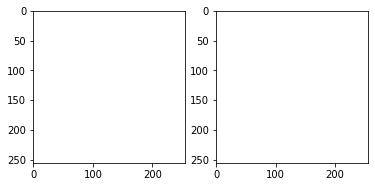

In [20]:
filename = 'dynamic_images'
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
fig, ax = plt.subplots(1,2)
for i in range(images):
    im0 = ax[0].imshow(test_gt_images[i, :].reshape(img_res,img_res), cmap=plt.get_cmap("gray"), vmin=0, vmax=1)
    im1 = ax[1].imshow(test_rollout_images[i, :].reshape(img_res,img_res), cmap=plt.get_cmap("gray"), vmin=0, vmax=1)
    ims.append([im0, im1])
    
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat=False)
plt.show()
ani.save(filename + '.mp4')
plt.close('all')

In [20]:
last_rows = torch.zeros((len(train_traj_data), 9))
other_rows = None
for i in range(len(train_traj_data)):
    last_rows[i] = train_traj_data[i]['states'][-1]
    if other_rows is not None:
        other_rows = torch.cat((other_rows, train_traj_data[i]['states'][:-1, :]), dim=0)
    else:
        other_rows = train_traj_data[i]['states'][:-1, :]

In [ ]:
last_rows_diff = (last_rows[:, 3:6] - last_rows[:, :3]).cpu()
other_rows_diff = (other_rows[:, 3:6] - other_rows[:, :3]).cpu()

In [34]:
np.linspace(0, 1, 7)

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        ])

In [32]:
images = 7
test_gt_images = np.ones((images, 256*256))
test_rollout_images = np.ones((images, 256*256))
pixels = np.linspace(0, 1, images)
for i in range(7):
    test_gt_images[i] = pixels[i]
    test_rollout_images[i] = pixels[i]

In [24]:
test_gt_images[6]

array([255., 255., 255., ..., 255., 255., 255.])

In [6]:
img_res = 256

In [ ]:
def update(frame):
    im0.set_array(test_gt_images[frame])
    im1.set_array(test_rollout_images[frame])
    return [im0, im1]

fig, ax = plt.subplots(1,2)
im0 = ax[0].imshow(np.zeros((256,256)), cmap=plt.get_cmap("gray"), vmin=0, vmax=1)
im1 = ax[1].imshow(np.zeros((256,256)), cmap=plt.get_cmap("gray"), vmin=0, vmax=1)

ani = animation.FuncAnimation(fig, update, frames=images, init_func=lambda: [im0, im1], blit=True)
ani.save('dynamic_images.mp4')
plt.show()

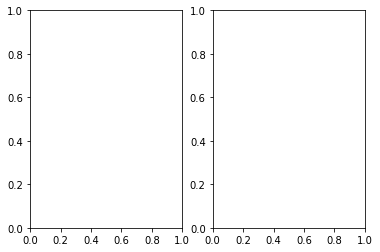

In [55]:
fit, ax = plt.subplots(1, 2)

In [58]:
im0 = ax[0].imshow(test_gt_images[0, :].reshape(img_res,img_res))

In [59]:
im0

In [60]:
im1 = ax[1].imshow(test_rollout_images[0, :].reshape(img_res,img_res))

In [61]:
im1

In [63]:
fit.show()

/Users/pradeepkadubandi/.local/share/virtualenvs/DemoPlanner--5SJrBy7/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """Entry point for launching an IPython kernel.


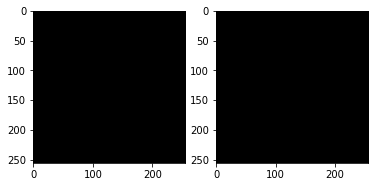

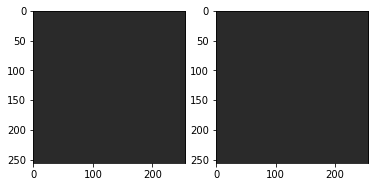

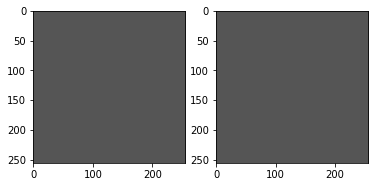

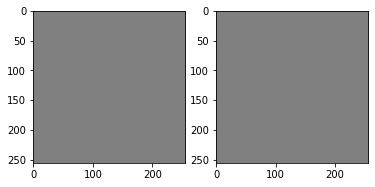

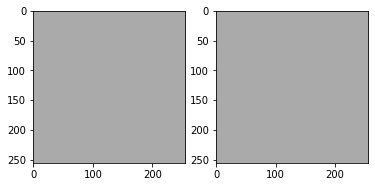

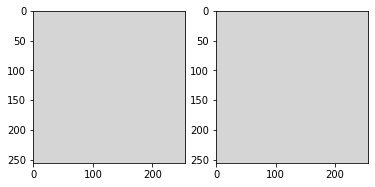

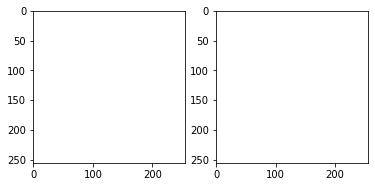

In [36]:
for i in range(len(test_gt_images)):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(test_gt_images[i, :].reshape(img_res,img_res), cmap=plt.get_cmap("gray"), vmin=0, vmax=1)
    plt.subplot(1,2,2)
    plt.imshow(test_rollout_images[i, :].reshape(img_res,img_res), cmap=plt.get_cmap("gray"), vmin=0, vmax=1)
    plt.show()
    plt.close(fig)

In [ ]:
fig = plt.figure()
plt.boxplot(last_rows_diff)
plt.show()
plt.close()

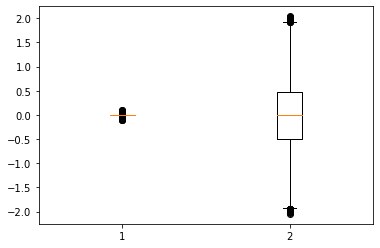

In [24]:
values = [last_rows_diff.reshape(-1), other_rows_diff.reshape(-1)]
fig = plt.figure()
plt.boxplot(values)
plt.show()
plt.close()